In [88]:
import numpy as np
from matplotlib import pyplot as plt

# mass in GeV/c^2
proton_mass = 0.938272
masses_dict = {'211': 0.139570, '2212': 0.938272, '3112': 1.197449, '321': 0.493677, '3222': 1.18937,
              '3312': 1.32171, '3334': 1.67245, '-211': 0.139570, '-2212': 0.938272, '-3112': 1.197449, 
              '-321': 0.493677, '-3222': 1.18937, '-3312': 1.32171, '-3334': 1.67245}

def get_particle_mass(p_index: str) -> float:
    if len(p_index) != 10:
        return masses_dict[p_index]
    else:
        m = (int(p_index) % 10000) // 10
        return float(m * proton_mass)
        

def calc_velocity(p: float, pz: float, ptype: str) -> float:
    return abs(pz) / np.sqrt(get_particle_mass(ptype) **2 + p**2 / 1**2)


def calc_time(v: float, distance: float) -> float:
    c = 2.99722458 * 10**8
    velocity = v * c
    time = distance / velocity
    return time


In [101]:

# storing = ["-211","211","2212"] #pions, protons
detector_in_radius = 0.015
detector_out_radius = 0.025

detector_distances = [1, 1.7, 2.5]
# detector_distances = [1]
n_rings = len(detector_distances)

events = []
particles_set = set()
particles_hit_set = set()
pion_line = ''
proton_line = ''
stopper = 15
counter_pi = 0
counter_pr = 0
amount = 100
time_pi = 0
time_pr = 0
b1 = 5
b2 = 5


time_scale = np.linspace(0,5, 20001)
pion_distribution = np.zeros(20001)
proton_distribution = np.zeros(20001)

for i in range(1, 12):
    filename = "data/data_" + str(i) + ".dat"
    with open(filename,'r') as inpf: 
        l = inpf.readline()
        l = inpf.readline()
        l = inpf.readline()
        l = inpf.readline()
        l = inpf.readline()
        
        for l in inpf.readlines():
            s=l.strip().split()
            if len(s) == 5:
                n,npart,b,bx,by = int(s[0]),int(s[1]),float(s[2]),float(s[3]),float(s[4])
                # 
                hits = []
                for j in range(n_rings):
                    hits.append([[],[]])     # for every detector, negative and positive Pz side
                phi_b = np.arctan2(bx,by)
                events.append([b,phi_b,hits])
            elif len(s) == 11:
                p_charge = int(s[0].strip())
                ptype = s[4].strip()
                # if len(ptype) > 5:
                    # ptype = '1000'
                px = float(s[5])
                py = float(s[6])
                pz = float(s[7])
                p_along = abs(pz)
                p_across = np.sqrt(px**2+py**2)
                p_full = np.sqrt(p_across **2 + p_along **2)
                
                if p_charge != 0:
                    particles_set.add(ptype)
                    for ind in range(n_rings):    # for every detector check if particle hit it
                        under_upper_bound = (p_across / p_along) < (detector_out_radius / detector_distances[ind])
                        above_lower_bound = (p_across / p_along) > (detector_in_radius / detector_distances[ind])
                        hit_detector =  under_upper_bound and above_lower_bound
                        if hit_detector:
                            
                            if (ptype == '211' or ptype == '-211') and ind == 2:
                                p_time = calc_time(calc_velocity(p_full, pz, '211'), 2.5)
                                norm_time = int((p_time * 10**9)// 0.001)
                                if norm_time > 20000:
                                    print(s)
                                else:
                                    pion_distribution[norm_time] += 1 
                                    
                                    
                            if (ptype == '2212' or ptype == '-2212') and ind == 2:
                                p_time = calc_time(calc_velocity(p_full, pz, '2212'), 2.5)
                                norm_time = int((p_time * 10**9)// 0.001)
                                if norm_time > 20000:
                                    print(s)
                                else:
                                    proton_distribution[norm_time] += 1     
                            
                            
                            
                            if len(pion_line) == 0 and (ptype == '211' or ptype == '-211') and ind == 0 :
                                if b1 < stopper:
                                    b1 += 1
                                else:
                                    pion_line = s
                            if len(proton_line) == 0 and (ptype == '2212' or ptype == '-2212') and ind == 0:
                                if b2 < stopper:
                                    b2 += 1
                                else:
                                    proton_line = s
                                    
                            if counter_pi < amount and ptype == '211' and ind == 0:        
                                time_pi += calc_time(calc_velocity(p_full, pz, '211'), 1)
                                counter_pi +=1
                            
                            if counter_pr < amount and ptype == '2212' and ind == 0:        
                                time_pr += calc_time(calc_velocity(p_full, pz, '2212'), 1)
                                counter_pr +=1
                                
                            particles_hit_set.add(ptype)
                            pnorm=np.sqrt(px**2+py**2+pz**2)
                            pxn=px/pnorm
                            pyn=py/pnorm
                            if pz > 0:
                                hits[ind][1].append([ptype, [pxn,pyn,pnorm]])
                            elif pz < 0:
                                hits[ind][0].append([ptype, [pxn,pyn,pnorm]])
                        

                        
    print("File #{} has been read".format(i))

particles_list = list(particles_set)
particles_list.sort()
phs = list(particles_hit_set)
phs.sort()
# print(particles_list)

print((time_pi/amount)-(time_pr/amount))



# events[j]: j - number of event, events[j][2] - info, events[j][2][i] i - number of detector,
# events[j][2][i][0/1] - negative or positive Pz, events[j][2][i][0/1][k] - k - number of hit 
# events[j][2][i][0/1][k][0] - particle type, events[j][2][i][0/1][k][1] - pxn, pyn, pnorm

File #1 has been read
File #2 has been read
['-1', '0', '0', '0', '-211', '-7.5619E-05', '1.4345E-04', '2.0104E-02', '9.3107E-01', '-2.0104E-02', '1.39570E-01']
File #3 has been read
File #4 has been read
['1', '0', '0', '0', '211', '-2.7600E-04', '-6.5964E-05', '-3.0798E-02', '6.4414E-01', '3.0798E-02', '1.39570E-01']
File #5 has been read
['1', '0', '0', '0', '211', '-2.3000E-04', '1.9046E-04', '3.0650E-02', '1.0037E+00', '-3.0650E-02', '1.39570E-01']
File #6 has been read
File #7 has been read
File #8 has been read
['1', '0', '0', '1', '2212', '6.2832E-04', '-2.0267E-03', '3.4095E-01', '7.7545E+00', '-3.4095E-01', '9.38280E-01']
File #9 has been read
File #10 has been read
['1', '0', '0', '1', '2212', '-1.2764E-03', '-3.1528E-03', '3.9861E-01', '8.2140E+00', '-3.9861E-01', '9.38280E-01']
File #11 has been read
8.367635891419287e-11


2469.0
16872.0


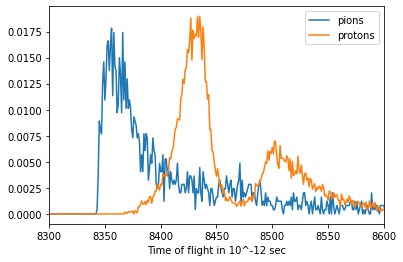

In [102]:
n_all_particles = len(particles_list)
# print(n_all_particles)
# print(len(phs))
# print(len(events))
events = sorted(events, key=lambda x: (x[0]))



pion_amount = np.sum(pion_distribution)
proton_amount = np.sum(proton_distribution)

print(pion_amount)
print(proton_amount)

pion_norm_distribution = pion_distribution / pion_amount
proton_norm_distribution = proton_distribution / proton_amount

start = 8300
end = 8600

plt.plot(pion_norm_distribution, label='pions')
plt.plot(proton_norm_distribution, label='protons')
plt.legend(loc='upper right')
plt.xlabel('Time of flight in 10^-12 sec')

plt.xlim(xmax = end, xmin = start)
plt.show()


In [91]:
print(pion_line)
print(proton_line)


v_pi = calc_velocity(np.sqrt(float(pion_line[7])**2 + float(pion_line[5])**2 + float(pion_line[6])**2),
                     float(pion_line[7]), '211')
print(v_pi)
v_pr = calc_velocity(np.sqrt(float(proton_line[7])**2 + float(proton_line[5])**2 + float(proton_line[6])**2),
                     float(proton_line[7]),'2212')
print(v_pr)
# 0.99815797446484
# 0.9951035446884804
# 0.9820843713668808
print()
print('Pion time is   {}'.format(calc_time(v_pi, 1)))
print('Proton time is {}'.format(calc_time(v_pr, 1)))
print('Proton came later on {} seconds'.format(calc_time(v_pr, 1) - calc_time(v_pi, 1)))


T = calc_time(v_pi,1)
print(T)
T = T * 10**9
print(T)
print((0.01* (T//0.01)))


['-1', '0', '0', '0', '-211', '3.1279E-03', '-3.9842E-02', '-1.8286E+00', '-1.2414E-01', '1.8286E+00', '1.39570E-01']
['1', '0', '0', '1', '2212', '-1.2875E-01', '-1.1559E-02', '-5.6444E+00', '-3.0453E-02', '5.6444E+00', '9.38280E-01']
0.9968631540330097
0.9862119439569009

Pion time is   3.346918757528281e-09
Proton time is 3.3830658910248318e-09
Proton came later on 3.6147133496550724e-11 seconds
3.346918757528281e-09
3.346918757528281
3.34
